In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import os
import calendar
import string
%matplotlib inline

In [2]:
# figure root
fig_root = os.environ['HOME']+'/work/E3SMv1_Future_Projection/figures'
save_fig = True

In [3]:
# set esgf
esgf_root = '/global/homes/q/qingli/project/cmip6_projection/esgf'
prefix_list0 = [filename[:-17] for filename in os.listdir(esgf_root) if filename.startswith('msft')]
prefix_list  = list(set(prefix_list0))
prefix_list

['msftyz_Omon_IPSL-CM6A-LR_historical_r21i1p1f1_gn',
 'msftmz_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn',
 'msftmz_Omon_CESM2_ssp585_r4i1p1f1_gn',
 'msftyz_Omon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn',
 'msftyz_Omon_IPSL-CM6A-LR_historical_r9i1p1f1_gn',
 'msftyz_Omon_IPSL-CM6A-LR_historical_r28i1p1f1_gn',
 'msftyz_Omon_UKESM1-0-LL_ssp585_r4i1p1f2_gn',
 'msftmz_Omon_CESM2-WACCM_historical_r3i1p1f1_gn',
 'msftmz_Omon_INM-CM5-0_historical_r10i1p1f1_gr1',
 'msftyz_Omon_IPSL-CM6A-LR_ssp585_r14i1p1f1_gn',
 'msftyz_Omon_UKESM1-0-LL_historical_r3i1p1f2_gn',
 'msftmz_Omon_MPI-ESM1-2-LR_ssp585_r8i1p1f1_gn',
 'msftyz_Omon_HadGEM3-GC31-MM_ssp585_r1i1p1f3_gn',
 'msftmz_Omon_MPI-ESM1-2-HR_ssp585_r2i1p1f1_gn',
 'msftyz_Omon_IPSL-CM6A-LR_historical_r10i1p1f1_gn',
 'msftmz_Omon_CESM2_historical_r11i1p1f1_gn',
 'msftyz_Omon_HadGEM3-GC31-LL_ssp585_r4i1p1f3_gn',
 'msftmz_Omon_INM-CM5-0_historical_r5i1p1f1_gr1',
 'msftmz_Omon_MPI-ESM1-2-HR_historical_r7i1p1f1_gn',
 'msftyz_Omon_HadGEM3-GC31-MM_historical_r3i1p1f3

In [4]:
#expid_sub = 'ssp585'
expid_sub = 'historical'
sources = []
for vprefix in prefix_list:
    var, realm, model, expid, variantid, gridid = vprefix.split('_')
    # index of atlantic sector
    if any([model.startswith(c) for c in ['MPI', 'CNRM', 'IPSL']]):
        idx_atlantic = 1
    else:
        idx_atlantic = 0
    s = {
        'prefix': vprefix,
        'variable': var,
        'realm': realm,
        'model': model,
        'expid': expid,
        'variantid': variantid,
        'gridid': gridid,
        'idx_atlantic': idx_atlantic,
    }
    if s['expid'] == expid_sub:
        sources.append(s)
    

In [5]:
sources[0]

{'prefix': 'msftyz_Omon_IPSL-CM6A-LR_historical_r21i1p1f1_gn',
 'variable': 'msftyz',
 'realm': 'Omon',
 'model': 'IPSL-CM6A-LR',
 'expid': 'historical',
 'variantid': 'r21i1p1f1',
 'gridid': 'gn',
 'idx_atlantic': 1}

In [6]:
# load esgf data
esgf_vars = []
for s in sources:
    print(s['prefix'])
    infile_list = [esgf_root+'/'+filename \
                   for filename in os.listdir(esgf_root) if filename.startswith(s['prefix'])]
    print('Opening {:d} files...'.format(len(infile_list)))
    dset = xr.open_mfdataset(infile_list, combine='by_coords')
    da = dset.data_vars[s['variable']]
    if s['model'].startswith('CESM'):
        # additional steps for CESM, cm to m for lev
        lev = da.lev.copy(data=da.lev.values/100.)
        da = da.assign_coords({'lev': lev})
    if s['model'].startswith('IPSL'):
        # additional steps for IPSL, drop x dimension and rename coordinates
        da = da.squeeze(drop=True)
        da = da.rename({'olevel': 'lev'})
        da = da.rename({'y': 'rlat'})
        tmp = da.nav_lat.values
        # the values of the last two element of rlat were the same, need to be different 
        tmp[-1] = tmp[-2]+1e-4
        rlat = da.nav_lat.copy(data=tmp)
        da = da.assign_coords({'rlat': rlat})
        da = da.rename({'3basin': 'basin'})
        #da = da.drop_vars(['nav_lat', 'nav_lon'])
    if s['model'].startswith('GFDL'):
        # additional steps for GFDL, rename coordinates
        da = da.rename({'y': 'rlat'})
    esgf_vars.append(da)
    dset.close()

msftyz_Omon_IPSL-CM6A-LR_historical_r21i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn
Opening 33 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r9i1p1f1_gn
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r28i1p1f1_gn
Opening 1 files...
msftmz_Omon_CESM2-WACCM_historical_r3i1p1f1_gn
Opening 1 files...


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftmz_Omon_INM-CM5-0_historical_r10i1p1f1_gr1
Opening 1 files...
msftyz_Omon_UKESM1-0-LL_historical_r3i1p1f2_gn
Opening 2 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r10i1p1f1_gn
Opening 1 files...
msftmz_Omon_CESM2_historical_r11i1p1f1_gn
Opening 4 files...


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftmz_Omon_INM-CM5-0_historical_r5i1p1f1_gr1
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r7i1p1f1_gn
Opening 33 files...
msftyz_Omon_HadGEM3-GC31-MM_historical_r3i1p1f3_gn
Opening 10 files...
msftyz_Omon_UKESM1-0-LL_historical_r10i1p1f2_gn
Opening 2 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r25i1p1f1_gn
Opening 1 files...
msftyz_Omon_UKESM1-0-LL_historical_r9i1p1f2_gn
Opening 2 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r17i1p1f1_gn
Opening 1 files...
msftyz_Omon_HadGEM3-GC31-MM_historical_r4i1p1f3_gn
Opening 10 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r7i1p1f1_gn
Opening 9 files...
msftmz_Omon_INM-CM5-0_historical_r8i1p1f1_gr1
Opening 1 files...
msftyz_Omon_UKESM1-0-LL_historical_r11i1p1f2_gn
Opening 2 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r27i1p1f1_gn
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r18i1p1f1_gn
Opening 1 files...
msftyz_Omon_HadGEM3-GC31-LL_historical_r5i1p1f3_gn
Opening 2 files...
msftmz_Omon_INM-CM5-0_historical_r3i1p1f1_gr1
Ope

/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftmz_Omon_MPI-ESM1-2-LR_historical_r8i1p1f1_gn
Opening 9 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r10i1p1f1_gn
Opening 9 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r32i1p1f1_gn
Opening 1 files...
msftyz_Omon_UKESM1-0-LL_historical_r2i1p1f2_gn
Opening 2 files...
msftyz_Omon_HadGEM3-GC31-LL_historical_r3i1p1f3_gn
Opening 2 files...
msftyz_Omon_HadGEM3-GC31-LL_historical_r4i1p1f3_gn
Opening 2 files...
msftyz_Omon_HadGEM3-GC31-MM_historical_r1i1p1f3_gn
Opening 10 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r3i1p1f1_gn
Opening 9 files...
msftmz_Omon_INM-CM5-0_historical_r1i1p1f1_gr1
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn
Opening 9 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r3i1p1f1_gn
Opening 33 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r9i1p1f1_gn
Opening 9 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r23i1p1f1_gn
Opening 1 files...
msftmz_Omon_CESM2_historical_r2i1p1f1_gn
Open

/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftyz_Omon_IPSL-CM6A-LR_historical_r14i1p1f1_gn
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r5i1p1f1_gn
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r26i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r8i1p1f1_gn
Opening 33 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r24i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn
Opening 9 files...
msftmz_Omon_CESM2_historical_r1i1p1f1_gn
Opening 1 files...


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftmz_Omon_INM-CM4-8_historical_r1i1p1f1_gr1
Opening 2 files...
msftyz_Omon_GFDL-ESM4_historical_r1i1p1f1_gn
Opening 9 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r8i1p1f1_gn
Opening 1 files...
msftmz_Omon_INM-CM5-0_historical_r7i1p1f1_gr1
Opening 1 files...
msftmz_Omon_CESM2_historical_r6i1p1f1_gn
Opening 1 files...


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftyz_Omon_IPSL-CM6A-LR_historical_r20i1p1f1_gn
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r16i1p1f1_gn
Opening 1 files...
msftmz_Omon_CESM2-WACCM_historical_r2i1p1f1_gn
Opening 1 files...


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftyz_Omon_IPSL-CM6A-LR_historical_r13i1p1f1_gn
Opening 1 files...
msftmz_Omon_CESM2_historical_r5i1p1f1_gn
Opening 1 files...


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftyz_Omon_UKESM1-0-LL_historical_r8i1p1f2_gn
Opening 2 files...
msftmz_Omon_INM-CM5-0_historical_r4i1p1f1_gr1
Opening 1 files...
msftyz_Omon_HadGEM3-GC31-MM_historical_r2i1p1f3_gn
Opening 10 files...
msftyz_Omon_GFDL-CM4_historical_r1i1p1f1_gn
Opening 9 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r4i1p1f1_gn
Opening 9 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r30i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r5i1p1f1_gn
Opening 33 files...
msftyz_Omon_UKESM1-0-LL_historical_r4i1p1f2_gn
Opening 2 files...
msftyz_Omon_UKESM1-0-LL_historical_r17i1p1f2_gn
Opening 2 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r9i1p1f1_gn
Opening 33 files...
msftmz_Omon_INM-CM5-0_historical_r2i1p1f1_gr1
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r12i1p1f1_gn
Opening 1 files...
msftmz_Omon_CESM2_historical_r3i1p1f1_gn
Opening 1 files...


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftyz_Omon_UKESM1-0-LL_historical_r18i1p1f2_gn
Opening 2 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r5i1p1f1_gn
Opening 9 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r7i1p1f1_gn
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r15i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r2i1p1f1_gn
Opening 33 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r6i1p1f1_gn
Opening 1 files...
msftmz_Omon_INM-CM5-0_historical_r6i1p1f1_gr1
Opening 1 files...
msftyz_Omon_UKESM1-0-LL_historical_r5i1p1f3_gn
Opening 2 files...
msftyz_Omon_UKESM1-0-LL_historical_r16i1p1f2_gn
Opening 2 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r22i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-LR_historical_r6i1p1f1_gn
Opening 9 files...
msftyz_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn
Opening 2 files...
msftyz_Omon_UKESM1-0-LL_historical_r19i1p1f2_gn
Opening 2 files...
msftyz_Omon_UKESM1-0-LL_historical_r7i1p1f3_gn
Opening 2 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r31i1p1f1_gn
Opening 

/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftyz_Omon_IPSL-CM6A-LR_historical_r19i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r10i1p1f1_gn
Opening 33 files...
msftyz_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn
Opening 2 files...
msftyz_Omon_HadGEM3-GC31-LL_historical_r2i1p1f3_gn
Opening 2 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r4i1p1f1_gn
Opening 1 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r6i1p1f1_gn
Opening 33 files...
msftmz_Omon_MPI-ESM1-2-HR_historical_r4i1p1f1_gn
Opening 33 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r11i1p1f1_gn
Opening 1 files...
msftyz_Omon_UKESM1-0-LL_historical_r6i1p1f3_gn
Opening 2 files...
msftmz_Omon_CESM2_historical_r10i1p1f1_gn
Opening 4 files...


/global/cfs/cdirs/e3sm/software/anaconda_envs/base/envs/e3sm_unified_1.3.0/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


msftmz_Omon_INM-CM5-0_historical_r9i1p1f1_gr1
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r2i1p1f1_gn
Opening 1 files...
msftyz_Omon_IPSL-CM6A-LR_historical_r3i1p1f1_gn
Opening 1 files...


msftyz_Omon_IPSL-CM6A-LR_historical_r21i1p1f1_gn
msftmz_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn
msftyz_Omon_IPSL-CM6A-LR_historical_r9i1p1f1_gn
msftyz_Omon_IPSL-CM6A-LR_historical_r28i1p1f1_gn
msftmz_Omon_CESM2-WACCM_historical_r3i1p1f1_gn
msftmz_Omon_INM-CM5-0_historical_r10i1p1f1_gr1
msftyz_Omon_UKESM1-0-LL_historical_r3i1p1f2_gn
msftyz_Omon_IPSL-CM6A-LR_historical_r10i1p1f1_gn
msftmz_Omon_CESM2_historical_r11i1p1f1_gn
msftmz_Omon_INM-CM5-0_historical_r5i1p1f1_gr1
msftmz_Omon_MPI-ESM1-2-HR_historical_r7i1p1f1_gn
msftyz_Omon_HadGEM3-GC31-MM_historical_r3i1p1f3_gn
msftyz_Omon_UKESM1-0-LL_historical_r10i1p1f2_gn
msftyz_Omon_IPSL-CM6A-LR_historical_r25i1p1f1_gn
msftyz_Omon_UKESM1-0-LL_historical_r9i1p1f2_gn
msftyz_Omon_IPSL-CM6A-LR_historical_r17i1p1f1_gn
msftyz_Omon_HadGEM3-GC31-MM_historical_r4i1p1f3_gn
msftmz_Omon_MPI-ESM1-2-LR_historical_r7i1p1f1_gn
msftmz_Omon_INM-CM5-0_historical_r8i1p1f1_gr1
msftyz_Omon_UKESM1-0-LL_historical_r11i1p1f2_gn
msftyz_Omon_IPSL-CM6A-LR_historical_r27i

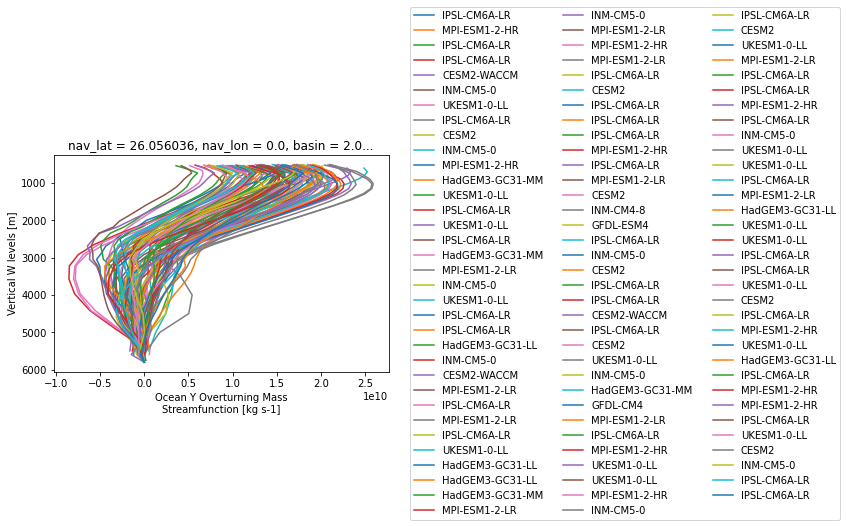

In [7]:
ns = len(sources)
tidx = 0
for i in np.arange(ns):
    da = esgf_vars[i]
    print(sources[i]['prefix'])
    if sources[i]['variable'] == 'msftmz':
        da.isel(basin=sources[i]['idx_atlantic']).sel(lat=26.5, 
                method='nearest').where(np.abs(da.lev)>500)[tidx].plot(y='lev', label=sources[i]['model'])
    else:
        da.isel(basin=sources[i]['idx_atlantic']).sel(rlat=26.5,
                method='nearest').where(np.abs(da.lev)>500)[tidx].plot(y='lev', label=sources[i]['model'])
plt.gca().invert_yaxis()
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=3)

In [8]:
esgf_amoc26 = []
for i, da in enumerate(esgf_vars):
    print(sources[i]['prefix'])
    if sources[i]['variable'] == 'msftmz':
        amoc = da.isel(basin=sources[i]['idx_atlantic']).sel(lat=26.5, 
                method='nearest').where(np.abs(da.lev)>500).max(dim='lev')
    else:
        amoc = da.isel(basin=sources[i]['idx_atlantic']).sel(rlat=26.5,
                method='nearest').where(np.abs(da.lev)>500).max(dim='lev')
    print(amoc.values.size)
    esgf_amoc26.append(amoc.values[:])

msftyz_Omon_IPSL-CM6A-LR_historical_r21i1p1f1_gn
1980
msftmz_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn
1980
msftyz_Omon_IPSL-CM6A-LR_historical_r9i1p1f1_gn
1980
msftyz_Omon_IPSL-CM6A-LR_historical_r28i1p1f1_gn
1980
msftmz_Omon_CESM2-WACCM_historical_r3i1p1f1_gn
1980
msftmz_Omon_INM-CM5-0_historical_r10i1p1f1_gr1
1980
msftyz_Omon_UKESM1-0-LL_historical_r3i1p1f2_gn
1980
msftyz_Omon_IPSL-CM6A-LR_historical_r10i1p1f1_gn
1980
msftmz_Omon_CESM2_historical_r11i1p1f1_gn
1980
msftmz_Omon_INM-CM5-0_historical_r5i1p1f1_gr1
1980
msftmz_Omon_MPI-ESM1-2-HR_historical_r7i1p1f1_gn
1980
msftyz_Omon_HadGEM3-GC31-MM_historical_r3i1p1f3_gn
1980
msftyz_Omon_UKESM1-0-LL_historical_r10i1p1f2_gn
1980
msftyz_Omon_IPSL-CM6A-LR_historical_r25i1p1f1_gn
1980
msftyz_Omon_UKESM1-0-LL_historical_r9i1p1f2_gn
1980
msftyz_Omon_IPSL-CM6A-LR_historical_r17i1p1f1_gn
1980
msftyz_Omon_HadGEM3-GC31-MM_historical_r4i1p1f3_gn
1980
msftmz_Omon_MPI-ESM1-2-LR_historical_r7i1p1f1_gn
1980
msftmz_Omon_INM-CM5-0_historical_r8i1p1f1_gr

In [9]:
esgf_data = np.array(esgf_amoc26)/1.e9
print(esgf_data.shape)

(101, 1980)


In [10]:
# monthly to annually
if expid_sub == 'ssp585':
    time = np.linspace(2015,2099,85)
elif expid_sub == 'historical':
    time = np.linspace(1850,2014,165)
ntime = len(time)
ns = len(sources)
esgf_data_ann = np.zeros([ns, ntime])
for i in np.arange(ntime):
    esgf_data_ann[:,i] = np.mean(esgf_data[:,i*12:(i+1)*12], axis=1)

Text(0, 0.5, 'AMOC (Sv)')

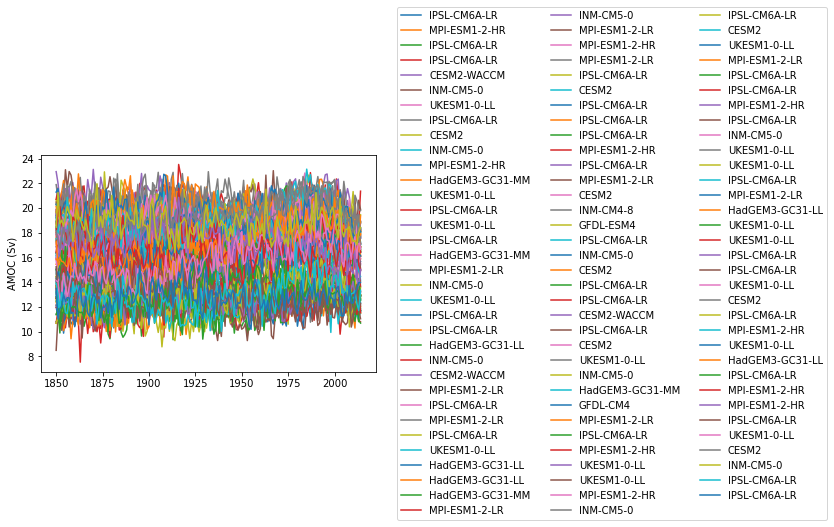

In [11]:
for i, s in enumerate(sources):
    plt.plot(time, esgf_data_ann[i, :], label=s['model'])
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=3)
plt.ylabel('AMOC (Sv)')

In [12]:
esgf_label = [s['model']+'_'+s['variantid'] for s in sources]
print(esgf_label)

['IPSL-CM6A-LR_r21i1p1f1', 'MPI-ESM1-2-HR_r1i1p1f1', 'IPSL-CM6A-LR_r9i1p1f1', 'IPSL-CM6A-LR_r28i1p1f1', 'CESM2-WACCM_r3i1p1f1', 'INM-CM5-0_r10i1p1f1', 'UKESM1-0-LL_r3i1p1f2', 'IPSL-CM6A-LR_r10i1p1f1', 'CESM2_r11i1p1f1', 'INM-CM5-0_r5i1p1f1', 'MPI-ESM1-2-HR_r7i1p1f1', 'HadGEM3-GC31-MM_r3i1p1f3', 'UKESM1-0-LL_r10i1p1f2', 'IPSL-CM6A-LR_r25i1p1f1', 'UKESM1-0-LL_r9i1p1f2', 'IPSL-CM6A-LR_r17i1p1f1', 'HadGEM3-GC31-MM_r4i1p1f3', 'MPI-ESM1-2-LR_r7i1p1f1', 'INM-CM5-0_r8i1p1f1', 'UKESM1-0-LL_r11i1p1f2', 'IPSL-CM6A-LR_r27i1p1f1', 'IPSL-CM6A-LR_r18i1p1f1', 'HadGEM3-GC31-LL_r5i1p1f3', 'INM-CM5-0_r3i1p1f1', 'CESM2-WACCM_r1i1p1f1', 'MPI-ESM1-2-LR_r8i1p1f1', 'IPSL-CM6A-LR_r1i1p1f1', 'MPI-ESM1-2-LR_r10i1p1f1', 'IPSL-CM6A-LR_r32i1p1f1', 'UKESM1-0-LL_r2i1p1f2', 'HadGEM3-GC31-LL_r3i1p1f3', 'HadGEM3-GC31-LL_r4i1p1f3', 'HadGEM3-GC31-MM_r1i1p1f3', 'MPI-ESM1-2-LR_r3i1p1f1', 'INM-CM5-0_r1i1p1f1', 'MPI-ESM1-2-LR_r1i1p1f1', 'MPI-ESM1-2-HR_r3i1p1f1', 'MPI-ESM1-2-LR_r9i1p1f1', 'IPSL-CM6A-LR_r23i1p1f1', 'CESM2_r2i1p

In [13]:
np.savez('esgf_amoc26_'+expid_sub+'.npz', data=esgf_data_ann, time=time, label=esgf_label)